In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA


import warnings
warnings.filterwarnings('ignore')

In [2]:
mpl.rcParams['figure.figsize'] = (12, 8)
mpl.rcParams['axes.grid'] = False

In [4]:
df = pd.read_csv("Anon_Cust_Order_Data.csv")
df.head()

,Order_ID,CustomerID,Date,State,City,ZIP,Product,Quantity,Price_Each
0,176558,1,4/19/19 8:46,TX,Dallas,75001,USB-C Charging Cable,2,11.95
1,176559,2,4/7/19 22:30,MA,Boston,2215,Bose SoundSport Headphones,1,99.99
2,176560,3,4/12/19 14:38,CA,Los Angeles,90001,Google Phone,1,600.00
3,176560,3,4/12/19 14:38,CA,Los Angeles,90001,Wired Headphones,1,11.99
4,176561,4,4/30/19 9:27,CA,Los Angeles,90001,Wired Headphones,1,11.99


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185950 entries, 0 to 185949
Data columns (total 9 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   Order_ID    185950 non-null  int64  
 1   CustomerID  185950 non-null  int64  
 2   Date        185950 non-null  object 
 3   State       185950 non-null  object 
 4   City        185950 non-null  object 
 5   ZIP         185950 non-null  int64  
 6   Product     185950 non-null  object 
 7   Quantity    185950 non-null  int64  
 8   Price_Each  185950 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 12.8+ MB


## Exploratory Data Analysis

First, we see that the date is stored as an object. Will update to datetime format.

Let's get to know the dataset
- Regional
- Products
- Price Range

- Bring in basic MSA information

Observations:
- Group by CustomerID to get statistics on cart size
- Figure out product characteristics and a tagging rationale

Helpful resource: https://otexts.com/fpp2/hierarchical.html

Census Regional Classification: https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf

In [6]:
region = {'CT': 'Northeast', 'ME':'Northeast', 'MA':'Northeast', 'NH':'Northeast', 'RI': 'Northeast', 'VT':'Northeast',
         'NJ':'Northeast', 'NY':'Northeast', 'PA':'Northeast', 'IN': 'Midwest', 'IL': 'Midwest', 'MI': 'Midwest', 'OH': 'Midwest',
         'WI': 'Midwest', 'IA': 'Midwest', 'KS': 'Midwest', 'MN': 'Midwest', 'MO': 'Midwest', 'NE': 'Midwest', 'ND': 'Midwest',
         'SD': 'Midwest', 'DE': 'South', 'DC': 'South', 'FL': 'South', 'GA': 'South', 'MD': 'South', 'NC': 'South', 'SC': 'South',
         'VA': 'South', 'WV': 'South', 'AL': 'South', 'KY': 'South', 'MS': 'South', 'TN': 'South', 'AK': 'South', 'LA': 'South',
         'OK': 'South', 'TX': 'South', 'AZ': 'West', 'CO': 'West', 'ID': 'West', 'NM': 'West', 'MT': 'West',
         'UT': 'West', 'NV': 'West', 'WY': 'West', 'AK': 'West', 'CA': 'West', 'HI': 'West', 'OR': 'West', 'WA': 'West',}


division = {'CT': 'New_Eng', 'ME':'New_Eng', 'MA':'New_Eng', 'NH':'New_Eng', 'RI': 'New_Eng', 'VT':'New_Eng',
         'NJ':'Middle_Atl', 'NY':'Middle_Atl', 'PA':'Middle_Atl', 'IN': 'East_No_Cent', 'IL': 'East_No_Cent', 'MI': 'East_No_Cent', 'OH': 'East_No_Cent',
         'WI': 'East_No_Cent', 'IA': 'We_No_Cent', 'KS': 'We_No_Cent', 'MN': 'We_No_Cent', 'MO': 'We_No_Cent', 'NE': 'We_No_Cent', 'ND': 'We_No_Cent',
         'SD': 'We_No_Cent', 'DE': 'So_Atl', 'DC': 'So_Atl', 'FL': 'So_Atl', 'GA': 'So_Atl', 'MD': 'So_Atl', 'NC': 'So_Atl', 'SC': 'So_Atl',
         'VA': 'So_Atl', 'WV': 'So_Atl', 'AL': 'East_So_Cent', 'KY': 'East_So_Cent', 'MS': 'East_So_Cent', 'TN': 'East_So_Cent', 'AK': 'We_So_Cent', 'LA': 'We_So_Cent',
         'OK': 'We_So_Cent', 'TX': 'We_So_Cent', 'AZ': 'Mountain', 'CO': 'Mountain', 'ID': 'Mountain', 'NM': 'Mountain', 'MT': 'Mountain',
         'UT': 'Mountain', 'NV': 'Mountain', 'WY': 'Mountain', 'AK': 'Pacific', 'CA': 'Pacific', 'HI': 'Pacific', 'OR': 'Pacific', 'WA': 'Pacific',}


In [7]:
df['Date'] =  pd.to_datetime(df['Date'], utc=True).dt.date
df['Date'] =  pd.to_datetime(df['Date'], infer_datetime_format=True)
df['Region'] = df['State'].map(region)
df['Division'] = df['State'].map(division)

In [8]:
df = df.sort_values('Date').reset_index(drop=True)

## Drop data from 2020-01-01 as it's skewing results:
df = df.loc[0:185915] 

display(df.tail(20))

,Order_ID,CustomerID,Date,State,City,ZIP,Product,Quantity,Price_Each,Region,Division
185896,310437,41165,2019-12-31,CA,Los Angeles,90001,USB-C Charging Cable,1,11.95,West,Pacific
185897,307873,38904,2019-12-31,CA,San Francisco,94016,AAA Batteries (4-pack),1,2.99,West,Pacific
185898,306319,37512,2019-12-31,NY,New York City,10001,USB-C Charging Cable,1,11.95,Northeast,Middle_Atl
185899,298051,30051,2019-12-31,CA,San Francisco,94016,Wired Headphones,1,11.99,West,Pacific
185900,306279,26700,2019-12-31,CA,Los Angeles,90001,Lightning Charging Cable,1,14.95,West,Pacific
185901,314935,45106,2019-12-31,CA,Los Angeles,90001,Wired Headphones,1,11.99,West,Pacific
185902,313883,44208,2019-12-31,GA,Atlanta,30301,AA Batteries (4-pack),1,3.84,South,So_Atl
185903,318900,33695,2019-12-31,TX,Dallas,75001,Wired Headphones,1,11.99,South,We_So_Cent
185904,314981,45147,2019-12-31,TX,Dallas,75001,27in FHD Monitor,1,149.99,South,We_So_Cent
185905,298109,30106,2019-12-31,GA,Atlanta,30301,Flatscreen TV,1,300.00,South,So_Atl


If there are columns that we won't need for analysis, we can drop them.

First, let's understand if order number and customer number are duplicative:

In [9]:
print(len(df['Order_ID'].unique()), len(df['CustomerID'].unique()))

display (df[['Order_ID', 'CustomerID']].sort_values('CustomerID').head(10))

178406 140768


,Order_ID,CustomerID
47882,176558,1
40715,176559,2
43843,176560,3
43846,176560,3
54821,176561,4
4384,150323,5
53949,176562,5
4528,150323,5
4499,150323,5
157976,292199,5


Confirmed that Order_ID and CustomerID contain different information. However, for our baseline timeseries forecast, we won't be aggregating that infomation so can drop those columns for now:

In [10]:
to_drop = ['Order_ID', 'CustomerID']

for col in df.columns:
    if col in to_drop:
        df.drop(col, axis=1, inplace=True)
        
display(df.head())

,Date,State,City,ZIP,Product,Quantity,Price_Each,Region,Division
0,2019-01-01,WA,Seattle,98101,27in 4K Gaming Monitor,1,389.99,West,Pacific
1,2019-01-01,TX,Dallas,75001,Macbook Pro Laptop,1,1700.00,South,We_So_Cent
2,2019-01-01,CA,Los Angeles,90001,ThinkPad Laptop,1,999.99,West,Pacific
3,2019-01-01,TX,Austin,73301,Flatscreen TV,1,300.00,South,We_So_Cent
4,2019-01-01,NY,New York City,10001,Flatscreen TV,1,300.00,Northeast,Middle_Atl


### Explore Geographic Subgroups

In [11]:
division_sum = df[['Region', 'Division', 'Quantity']].groupby(by=['Region', 'Division']).sum().reset_index()
state_sum = df[['State', 'Quantity']].groupby(by=['State']).sum().reset_index()
display(division_sum)
display(state_sum)

,Region,Division,Quantity
0,Northeast,Middle_Atl,27916
1,Northeast,New_Eng,25274
2,South,So_Atl,16602
3,South,We_So_Cent,27879
4,West,Pacific,111367


,State,Quantity
0,CA,83514
1,GA,16602
2,MA,22524
3,ME,2750
4,NY,27916
5,OR,11301
6,TX,27879
7,WA,16552


<AxesSubplot: xlabel='State', ylabel='Quantity'>

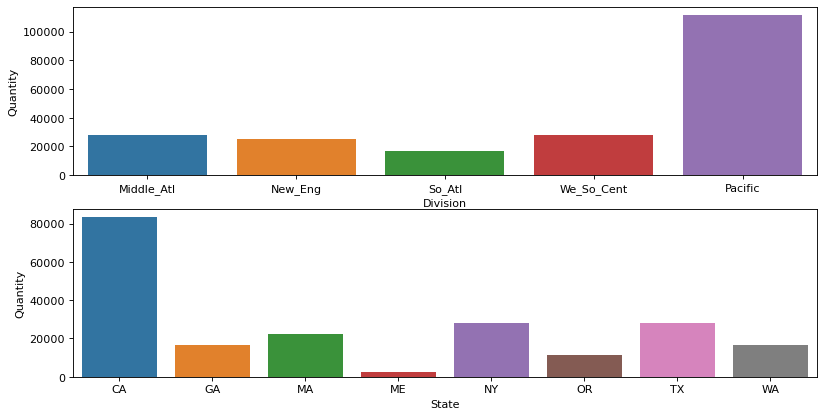

In [12]:
fig, axes = plt.subplots(2, 1, figsize=(12,6), dpi= 80)
sns.barplot(x='Division', y='Quantity', data=division_sum, ax=axes[0])
sns.barplot(x='State', y='Quantity', data=state_sum, ax=axes[1])